In [18]:
import numpy as np

import torch
import torch.nn as nn

import jax.numpy as jnp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

from kernel_sca_inducing_points import *
from kernels import *
from utils import *

In [11]:
def DDM(mu, sequence_length, sigma=0.35, dt=1, seed=None):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)
    x = np.zeros((num_trajectories, num_steps + 1))

    for i in range(num_trajectories):
        for t in range(num_steps):
            x[i, t + 1] = x[i, t] + mu[i] * dt + sigma * np.sqrt(dt) * np.random.normal()
    
    p = np.sign(mu)                                                                         #p is of shape K, with -1 or 1 based on sign(mu_k)
    x = x[:, :, None]                                                                       #x is K=mu="batch_sz", T, 1
    return torch.tensor(x, dtype=torch.float32), torch.tensor(p, dtype=torch.float32)

def mse_loss(z_all, p):
    zeros = torch.zeros_like(p)
    p_all = torch.stack([zeros, p]).T
    z_comp = torch.stack([z_all[:,0].squeeze(), z_all[:,-1].squeeze()]).T
    return torch.mean((z_comp - p_all) ** 2)
    
class DriftDiffusionRNN(torch.nn.Module):
    def __init__(self, hidden_size, input_size, output_size):
        super(DriftDiffusionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNNCell(input_size, hidden_size, nonlinearity='tanh')       #1 --> H=100
        self.fc = torch.nn.Linear(hidden_size, output_size)                             #H=100 --> 1

    def forward(self, x):
        h_i = torch.zeros(x.shape[0], self.hidden_size)                                 #h_i = [K, H=100]
        ls_h_i = []
        ls_z = []
        for i in range(x.shape[1]):
            h_i = self.rnn(x[:, i, :], h_i)
            ls_h_i.append(h_i)
            z = self.fc(h_i)                                                            #momentary evidence z [K,]
            ls_z.append(z)
        #z = torch.tanh(z)
        z_all = torch.stack(ls_z, dim=1)                                                #K, T, 1                                                         
        return z_all, ls_h_i

def train_model(model, optimizer, mu, iterations=10, total_time=50, save_path = 'model.pth'):
    model.train()
    ls_loss = []
    for iter in range(iterations):
        x, p = DDM(mu, total_time)
        optimizer.zero_grad()
        z_all, ls_h_i = model(x)  
        loss = mse_loss(z_all, p)
        loss.backward()
        optimizer.step()

        ls_loss.append(loss.item())
        print(f'Iteration [{iter+1}/{iterations}], Loss: {loss.item():.4f}')
    #torch.save(model.state_dict(), save_path)
    return ls_loss, z_all

mu = np.array([-0.64, -0.32, -0.16, -0.08, -0.04, 0.04, 0.08, 0.16, 0.32, 0.64])  

lr=1e-3
total_time=100
iterations=1500
model = DriftDiffusionRNN(hidden_size=100, input_size=1, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

ls_loss, z_all = train_model(model, optimizer, mu,  iterations=iterations, total_time=total_time)




Iteration [1/2000], Loss: 0.2770
Iteration [2/2000], Loss: 0.1323
Iteration [3/2000], Loss: 0.0714
Iteration [4/2000], Loss: 0.0920
Iteration [5/2000], Loss: 0.0889
Iteration [6/2000], Loss: 0.1934
Iteration [7/2000], Loss: 0.0686
Iteration [8/2000], Loss: 0.2763
Iteration [9/2000], Loss: 0.0316
Iteration [10/2000], Loss: 0.0547
Iteration [11/2000], Loss: 0.1661
Iteration [12/2000], Loss: 0.0198
Iteration [13/2000], Loss: 0.0185
Iteration [14/2000], Loss: 0.0438
Iteration [15/2000], Loss: 0.1028
Iteration [16/2000], Loss: 0.0326
Iteration [17/2000], Loss: 0.0350
Iteration [18/2000], Loss: 0.2855
Iteration [19/2000], Loss: 0.0172
Iteration [20/2000], Loss: 0.0136
Iteration [21/2000], Loss: 0.0459
Iteration [22/2000], Loss: 0.0336
Iteration [23/2000], Loss: 0.0299
Iteration [24/2000], Loss: 0.0716
Iteration [25/2000], Loss: 0.0043
Iteration [26/2000], Loss: 0.0117
Iteration [27/2000], Loss: 0.0071
Iteration [28/2000], Loss: 0.0115
Iteration [29/2000], Loss: 0.0585
Iteration [30/2000], Lo

/Users/ariellerosinski/miniforge3/envs/sca_project/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


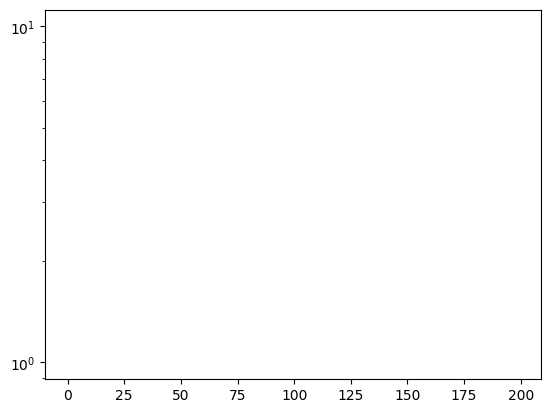

In [24]:
plt.semilogy(ls_loss)

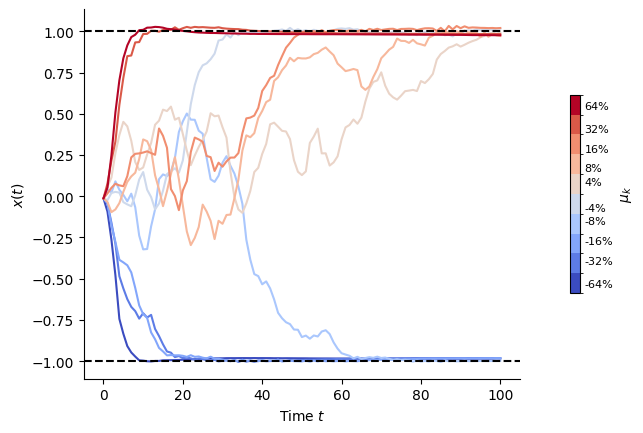

In [23]:
# for i in range(10):
#     plt.plot(z_all[i, :].detach().numpy())

fig, ax = plt.subplots()
boundaries = np.concatenate(([mu[0] - (mu[1] - mu[0])/2], (mu[:-1] + mu[1:])/2, [mu[-1] + (mu[-1] - mu[-2])/2]))
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(mu))
cmap = plt.get_cmap('coolwarm', len(mu))

for i, m in enumerate(mu):
    ax.plot(z_all[i, :].detach().numpy(), color=cmap(norm(m)))

ax.axhline(y=1, color='black', linestyle='--')
ax.axhline(y=-1, color='black', linestyle='--')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'$x(t)$')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
 
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, ticks=mu)
cbar.ax.tick_params(size=0) 
cbar.set_label('$\mu_k$')
cbar.set_ticklabels([f'{100*m:.0f}%' for m in mu], fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [14]:
x, p = DDM(mu, sequence_length=50)
z, ls_h_i = model(x)

ls_X = [jnp.array(tensor.detach().numpy()) for tensor in ls_h_i]
X = jnp.stack(ls_X, axis=1).swapaxes(1,2) 
X, _ = pre_processing(X, soft_normalize=None, center=False)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)          
A = A.reshape(N,-1)   



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 0.7847288846969604, S_ratio: 0.051782697439193726
Iteration 10, S: 10.269696235656738, S_ratio: 0.12357306480407715
Iteration 20, S: 32.14795684814453, S_ratio: 0.23096472024917603
Iteration 30, S: 55.8250617980957, S_ratio: 0.2926468849182129
Iteration 40, S: 85.34520721435547, S_ratio: 0.338794082403183
Iteration 50, S: 124.37677001953125, S_ratio: 0.3812607526779175
Iteration 60, S: 170.00205993652344, S_ratio: 0.3605518937110901
Iteration 70, S: 191.6591033935547, S_ratio: 0.40058478713035583
Iteration 80, S: 168.66705322265625, S_ratio: 0.3816490173339844
Iteration 90, S: 206.37289428710938, S_ratio: 0.3731333911418915
Iteration 100, S: 176.14556884765625, S_ratio: 0.32263314723968506
Iteration 110, S: 276.5700378417969, S_ratio: 0.4133758544921875
Iteration 120, S: 281.4882507324219, S_ratio: 0.351174533367157
Iteration 130, S: 269.9869079589844, S_ratio: 0.39598241448402405
Iteration 140, S: 254.17706298828125, S_ratio: 0.297682523727417
Iteration 150, S: 219.410

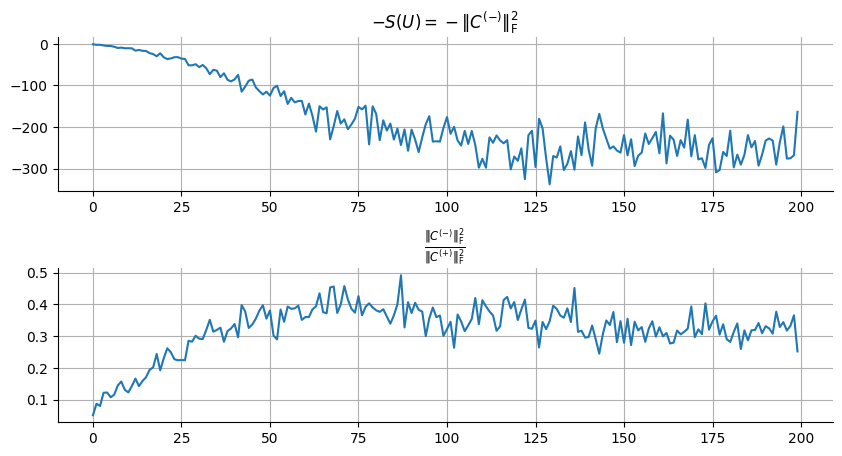

In [15]:

kernel_function=K_X_Y_squared_exponential
d = 2
c = 30
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )

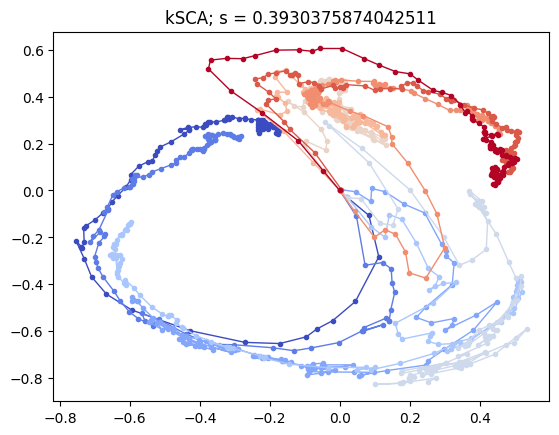

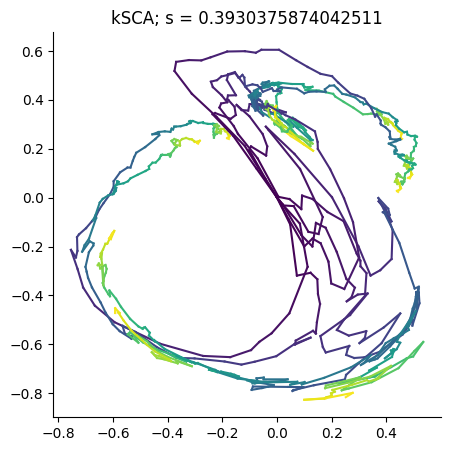

<Figure size 640x480 with 0 Axes>

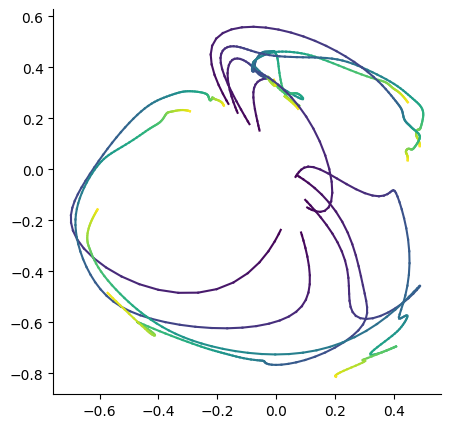

In [16]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, _, _, _  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

fig = plt.figure()
ax = fig.add_subplot(111) #projection='3d'
cmap = plt.get_cmap('coolwarm', K)
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]

    color = cmap(k / (K - 1)) 
    ax.plot(x, y, linestyle='-', marker='.', linewidth=1, color=color)
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')


plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=4)
plt.figure()
plot_2D(Y_smoothed)